## Setting up connection to TM1 

In [10]:
#import TM1py services
from TM1py.Services import TM1Service
from TM1py.Utils import Utils

In [11]:
#TM1 Log In Credential
ADDRESS = "V00WATM1APP01D"
PORT = 8010
USER = "admin"
PWD = "apple"
SSL = True

In [12]:
#Connect to the TM1 instance
tm1 = TM1Service(address=ADDRESS, port=PORT, user=USER, password=PWD, ssl=SSL)

In [13]:
# TM1 cube view 
cube_name = 'Retail Sales'
view_name = 'z_Store_Sales'

## Getting data as (pandas) dataframe
    * Get TM1 view data as a pandas dataframe
    * Pandas df is easy to do data exploratory analysis

In [14]:
%time
df = tm1.cubes.cells.execute_view_dataframe(cube_name=cube_name, view_name=view_name, private=False)

Wall time: 0 ns


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
sales=df.drop(['Measure'], axis=1)
sales.rename(columns={'Time': 'Date', 'Value':'Weekly_Sales','Holiday':'IsHoliday'}, inplace=True)
sales['Date']=pd.to_datetime(sales['Date'])
sales["Store"] = sales["Store"].astype(np.int64)
sales["IsHoliday"] = sales["IsHoliday"].astype(bool)
print (sales.dtypes)



Store                    int64
Department              object
Date            datetime64[ns]
IsHoliday                 bool
Weekly_Sales           float64
dtype: object


## Reading data from a CSV file

In [21]:
# pd.read_csv will store the information into a pandas dataframe called df
stores = pd.read_csv('stores data-set.csv')
features = pd.read_csv('Features data set.csv')

In [22]:
features['Date'] = pd.to_datetime(features['Date'])

print(features.dtypes)

Store                    int64
Date            datetime64[ns]
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
dtype: object


In [23]:
df=pd.merge(sales,features, on=["Store","Date", "IsHoliday"], how='left')
df=pd.merge(df,stores, on=["Store"], how='left')
df=df.fillna(0)


In [24]:
df_average_sales_week = df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
df_average_sales = df_average_sales_week.sort_values('Weekly_Sales', ascending=False)

len(df_average_sales[df_average_sales.duplicated()])


0

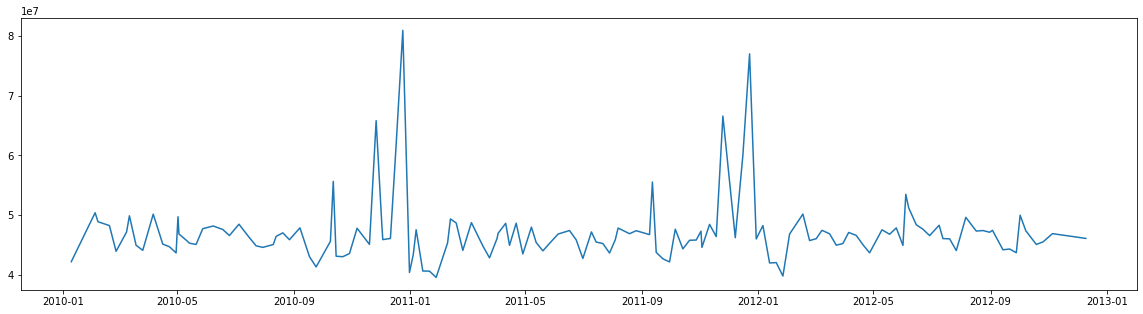

In [25]:

plt.figure(figsize=(20,5))
plt.plot(df_average_sales_week.Date, df_average_sales_week.Weekly_Sales)
plt.show()

In [26]:
# head and tail weeks
df_average_sales.head(5)
df_average_sales.tail(5)
new_df = df_average_sales.head(5).append(df_average_sales.tail(5))
print (new_df)

          Date  Weekly_Sales
46  2010-12-24   80931415.60
98  2011-12-23   76998241.31
95  2011-11-25   66593605.26
41  2010-11-26   65821003.24
45  2010-12-17   61820799.85
50  2011-01-14   40673678.04
51  2011-01-21   40654648.03
47  2010-12-31   40432519.00
103 2012-01-27   39834974.67
52  2011-01-28   39599852.99


In [27]:
# Top performing stores in term of sales
df_top_stores = df.groupby(by=['Store','Date'], as_index=False)['Weekly_Sales'].sum()
df_top_stores.sort_values('Weekly_Sales', ascending=False)[:5]

,Store,Date,Weekly_Sales
1905,14,2010-12-24,3818686.45
2763,20,2010-12-24,3766687.43
1333,10,2010-12-24,3749057.69
527,4,2011-12-23,3676388.98
1762,13,2010-12-24,3595903.20


In [46]:
# convert to a time series for modeling
ts = df_average_sales_week.set_index('Date')
ts.asfreq('D')
ts.index

DatetimeIndex(['2010-01-10', '2010-02-04', '2010-02-07', '2010-02-19',
               '2010-02-26', '2010-03-09', '2010-03-12', '2010-03-19',
               '2010-03-26', '2010-04-06',
               ...
               '2012-09-03', '2012-09-14', '2012-09-21', '2012-09-28',
               '2012-10-02', '2012-10-08', '2012-10-19', '2012-10-26',
               '2012-11-05', '2012-12-10'],
              dtype='datetime64[ns]', name='Date', length=143, freq=None)

In [45]:
import warnings
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
%matplotlib inline

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

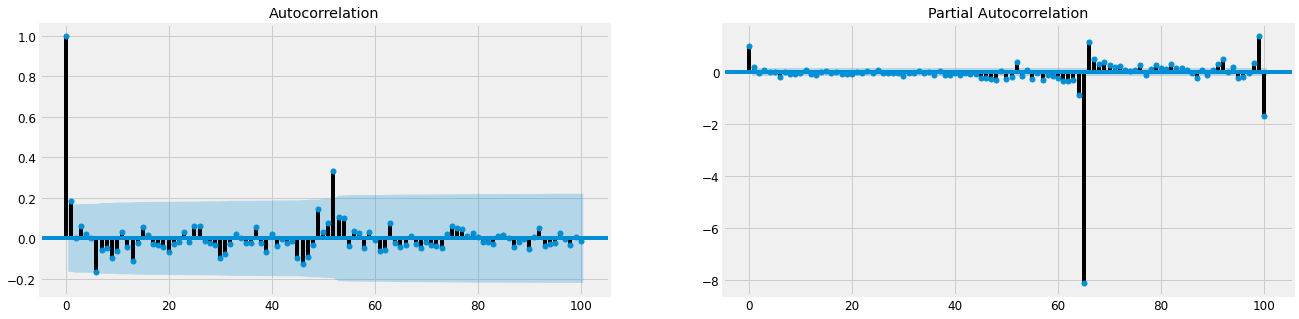

In [47]:
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(ts, lags=100, ax=axes[0])
plot_pacf(ts, lags=100, ax=axes[1])
plt.show()